<a href="https://colab.research.google.com/github/JLopez86/plant_disease/blob/main/04_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#4. Transferencia de Aprendizaje

##4.1. Instalación de Requerimientos

In [1]:
# Instalación del cliente Neptune
! pip install neptune-client[fastai]

# Actualización de Matplotlib
! pip install matplotlib --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.7/444.7 KB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.3/55.3 KB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 KB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.9/840.9 KB 38.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 66.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 KB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 KB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.5/135.5 KB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.

In [1]:
# Importación de librerías
from google.colab import files
from google.colab import drive
from fastai.vision.all import *
from fastai.callback.hook import *
from fastai.imports import *
from fastai.torch_core import *
from fastai.learner import *
import os
import shutil
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
print('matplotlib: {}'.format(matplotlib.__version__))

from torch import optim
from functools import partial
import pandas as pd

# Importación de librerías para integración Fastai | Neptune
import neptune.new as neptune
from neptune.new.integrations.fastai import NeptuneCallback

#from nbdev.showdoc import show_doc

# Verificación de activación de GPU
print(torch.cuda.is_available())

matplotlib: 3.6.3
True


In [2]:
# Montar el drive y extraer el conjunto de datos
drive.mount('/content/drive')
# Descomprimir imágenes para entrenamiento y validación
! unzip /content/drive/MyDrive/Colab\ Notebooks/Data\ Folder/Plant_Disease.zip
# Descomprimir imágenes para pruebas
! unzip /content/drive/MyDrive/Colab\ Notebooks/Validation\ Folder/validation.zip

Mounted at /content/drive
Archive:  /content/drive/MyDrive/Colab Notebooks/Data Folder/Plant_Disease.zip
   creating: Plant_Disease/
   creating: Plant_Disease/Powdery/
  inflating: Plant_Disease/Powdery/cb89e22ed61c53e8.jpg  
  inflating: Plant_Disease/Powdery/e739712c1c37b1c1.jpg  
  inflating: Plant_Disease/Powdery/f9011ffc0a4552af.jpg  
  inflating: Plant_Disease/Powdery/fc070f831ef0653c.jpg  
  inflating: Plant_Disease/Powdery/8f838afd2c62b2c6.jpg  
  inflating: Plant_Disease/Powdery/e6b330d8994b6c69.jpg  
  inflating: Plant_Disease/Powdery/dc597b339482e585.jpg  
  inflating: Plant_Disease/Powdery/e578f96ed4d40618.jpg  
  inflating: Plant_Disease/Powdery/83c5b3ab0bbc98c6.jpg  
  inflating: Plant_Disease/Powdery/c83969eb294d2637.jpg  
  inflating: Plant_Disease/Powdery/bba49317683af03a.jpg  
  inflating: Plant_Disease/Powdery/bd3e64f2da30c324.jpg  
  inflating: Plant_Disease/Powdery/ccb2129857236f6e.jpg  
  inflating: Plant_Disease/Powdery/899e3b7cc043cecc.jpg  
  inflating: Plant_

##4.2. Definición del Conjunto de Datos

In [3]:
# Cargar el conjunto de datos en memoria
path = 'Plant_Disease'
files = get_image_files(path)

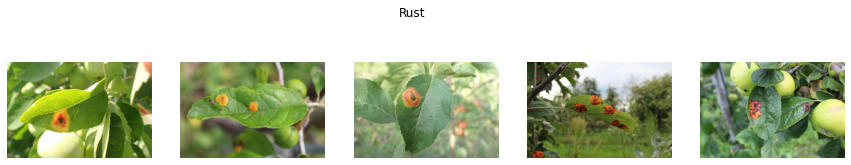

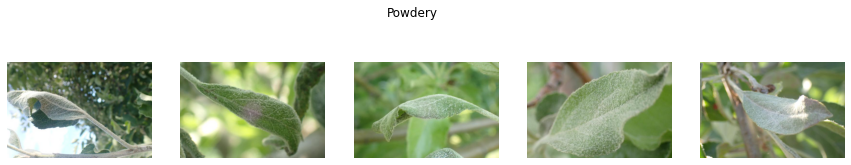

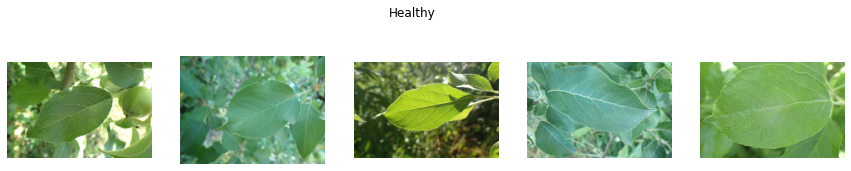

In [4]:
# Etiquetas del dataset y visualización de las muestras
labels = os.listdir(path)
dataset = {}
for label in labels:
  images = get_image_files(path, folders=label)
  dataset[label] =len(images)
  sample = [load_image(image) for image in images.shuffle()[:5]]
  show_images(sample, nrows=1, ncols=5, imsize=3, suptitle=label)

In [5]:
# Definición de funciones
# Cargar el conjunto de datos y distribuir para entrenamiento y validación
def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value) 
    torch.manual_seed(seed_value) 
    random.seed(seed_value) 
    if use_cuda: 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) 
        torch.backends.cudnn.deterministic = True  
        torch.backends.cudnn.benchmark = False


# Función para la definición del dataloader
def get_dataloader(bs = 64, size=224, val=0.20, mult=1, seed = 42, cuda = False): 
  print(f"* Cargando imágenes desde {path}:")
  print(f"    Se usará {len(labels)} etiquetas: {labels}")
  print(f"    Se reservó {1-val:.0%} de los datos para el entrenamiento")
  dataloader = ImageDataLoaders.from_folder(
  path, 
  vocab=labels, 
  item_tfms=Resize(size),
  valid_pct=val, 
  batch_tfms=aug_transforms(mult=mult),
  bs = bs,
  seed = random_seed(seed_value = seed, use_cuda = cuda)
  )
  return dataloader

  # Función del aprendiz de vision
def set_vision_learner(modelo = resnet34, monitor = 'accuracy', patience = 3, **kwargs):
  return vision_learner(
      dataloader,
      arch = modelo,
      metrics=[accuracy, error_rate], 
      path='/content/',
      model_dir='models',
      cbs=[neptune_callback, 
           EarlyStoppingCallback(monitor=monitor, min_delta=0.01, patience=patience), 
           SaveModelCallback(monitor=monitor, min_delta=0.01),
           ActivationStats(with_hist=True)],
      **kwargs
       
  )

In [8]:
dataloader = get_dataloader(val=0.20)

* Cargando imágenes desde Plant_Disease:
    Se usará 3 etiquetas: ['Rust', 'Powdery', 'Healthy']
    Se reservó 80% de los datos para el entrenamiento


In [9]:
# Verificación
plot_labels = []
plot_train_imgs = []
plot_valid_imgs = []
for label in labels:
    num_train_imgs = len([path for path in dataloader.train_ds.items if path.parent.name == label])
    num_valid_imgs = len([path for path in dataloader.valid_ds.items if path.parent.name == label])
    plot_labels.append(label)
    plot_train_imgs.append(num_train_imgs)
    plot_valid_imgs.append(num_valid_imgs)
    print(f"* Para '{label}...'")
    print(f"   Se tiene {num_train_imgs} imágenes de entrenamiento")
    print(f"   Se tiene {num_valid_imgs} imágenes de validación")

* Para 'Rust...'
   Se tiene 391 imágenes de entrenamiento
   Se tiene 93 imágenes de validación
* Para 'Powdery...'
   Se tiene 395 imágenes de entrenamiento
   Se tiene 85 imágenes de validación
* Para 'Healthy...'
   Se tiene 392 imágenes de entrenamiento
   Se tiene 116 imágenes de validación


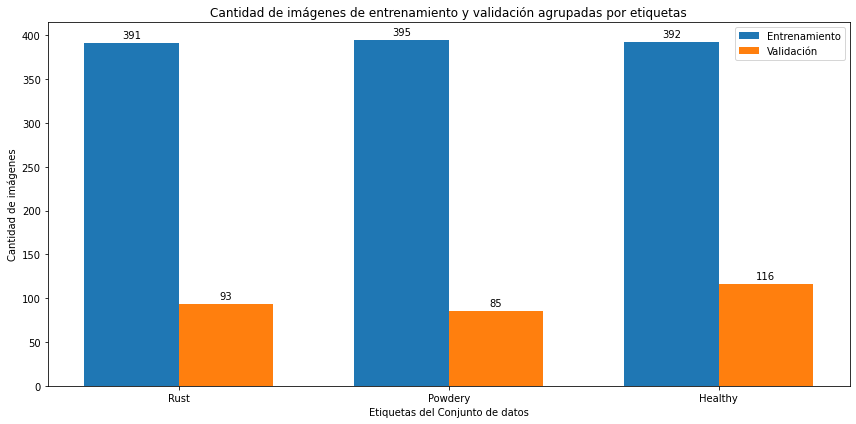

In [10]:
# Gráficos de la distribución del dataloader
x = np.arange(len(plot_labels))
width = 0.35

fig, ax = plt.subplots(figsize=(12,6))
rects1 = ax.bar(x - width/2, plot_train_imgs, width, label='Entrenamiento')
rects2 = ax.bar(x + width/2, plot_valid_imgs, width, label='Validación')

ax.set_ylabel('Cantidad de imágenes')
ax.set_xlabel('Etiquetas del Conjunto de datos')
ax.set_title('Cantidad de imágenes de entrenamiento y validación agrupadas por etiquetas')
ax.set_xticks(x, plot_labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

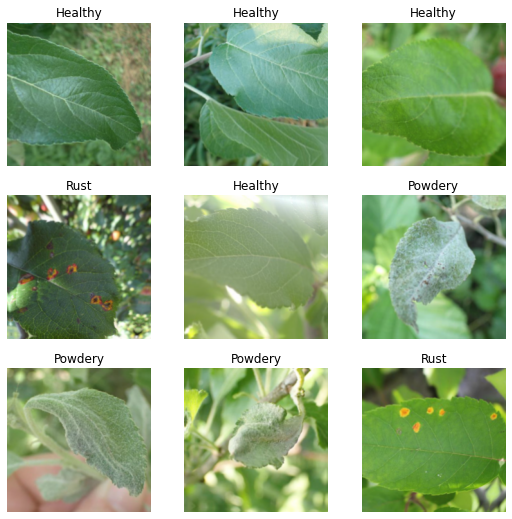

In [12]:
dataloader.show_batch()

##4.3. Entrenamiento del Modelo

In [14]:
# Definición del Learner
learner = vision_learner(dataloader, 
                         resnet50,
                         path='/content/',
                         model_dir='models', 
                         metrics=[accuracy, error_rate], 
                         cbs=ActivationStats(with_hist=True),
                         )

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [15]:
# Resumen del Learner
learner.summary()

/usr/local/lib/python3.8/dist-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


Sequential (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
____________________________________________________________________________
                     64 x 256 x 56 x 56  
Conv2d                                    16384      False     
BatchNorm2d                        

SuggestedLRs(valley=0.0006918309954926372)

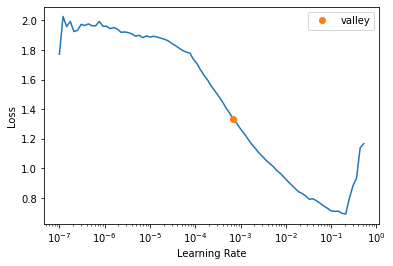

In [16]:
lr = learner.lr_find()
lr

In [ ]:
learner.fine_tune(1, lr[0])

epoch,train_loss,valid_loss,accuracy,error_rate,time


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.848298,0.141682,0.962585,0.037415,06:46


epoch,train_loss,valid_loss,accuracy,error_rate,time


In [ ]:
lr[0] - (lr[0] * 35 / 100)

0.001129570504417643

In [ ]:
# Función para graficar las metricas de pérdida de entrenamiento y validación, precisión y error en la validación
@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

### 4.3.1 Entrenamiento y optimización

In [ ]:
#Definición de Hyperparámetros
bs = 32
epochs = 20
models = [resnet34, vgg16, mobilenet_v3_large]
optimizers = [Adam, SGD]
learners = []

In [ ]:
# Entrenando del modelo y registrando en Neptune
dataloader = get_dataloader(bs = bs)
for model in models: 
  for opt in optimizers:
    run = neptune.init_run(
        project="racosta93/PDI",
        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxMDYyZjBhNS0zZjZhLTRjODEtYTJlMi00Yzk3ZDQ1NDFiM2IifQ==",)
    neptune_callback = NeptuneCallback(run=run)
    learner_opt = set_vision_learner(modelo = model, monitor='valid_loss', patience = 10, opt_func= opt)
    lr = learner_opt.lr_find()
    learner_opt.summary()
    learner_opt.fine_tune(epochs, lr[0])
    learners.append(learner_opt)
    run.stop()

##4.4. Intepretación de Resultados

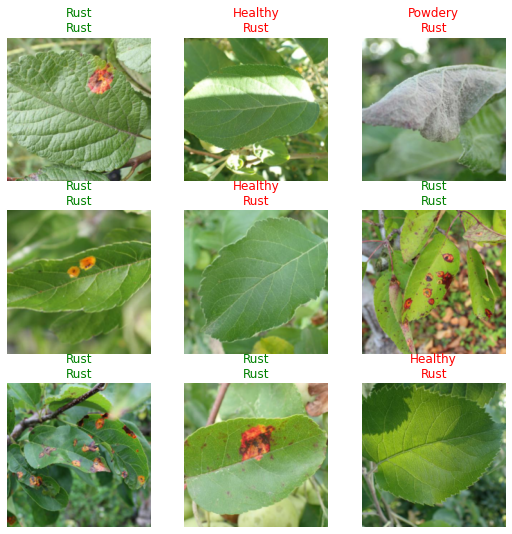

In [ ]:
modelos_opt = ['resnet50_SGD', 'resnet50_Adam',
               'vgg16_SGD', 'vgg16_adam',
               'mobilenet_v3_large_SGD', 'mobilenet_v3_large_adam']
i=0

for learner in learners:
#for learner in [learner_SGD, learner_Adam, learner_RMS]:
    learning_interpreter = ClassificationInterpretation.from_learner(learner)
    #Matriz de confusión
    learning_interpreter.plot_confusion_matrix(title = f'Matriz de confución de {modelos_opt[i]}',
                                               normalize = True,
                                               cmap = "Greens",
                                               figsize = (5, 5),)
    i += 1
    
    #Top losses
    try:
        learning_interpreter.plot_top_losses(9, figsize=(15,10))
    except:
        print('No es posible mostrar el "Plot Top Losses", el número de muestras es demasiado')

##4.5. Predicción

In [ ]:
# Función para predecir imagen
def pred_img(img_path):
  dirs = os.listdir(path)
  dirs.copy()
  dirs.sort()
  img = PILImage.create(img_path)
  pred,c,probs = learn.predict(img)
  print('-'*95)
  print(f" Predicción: {pred}.")
  print(f" Probabilidad: {probs[c].item()*100:.2f}%")
  print('-'*95)
  figura = plt.figure(figsize = (12,3))
  figura.subplots_adjust(hspace=1.5, wspace=0.5)
  grafico1 = figura.add_subplot(121)
  grafico2 = figura.add_subplot(122)
  grafico1.imshow(img)
  grafico2.bar(dirs, probs.tolist(), width=.85)
  grafico1.set_title('Visualización de la Imagen')
  grafico2.set_title('Probabilidad de clases')
  grafico2.set_ylabel('Probabilidad 0 - 1')
  grafico2.set_xlabel('Etiquetas / Clases')
  plt.show()

In [ ]:
# Función para predecir imagen
def pred_img(img_path, learner):
  dirs = os.listdir(path)
  dirs.copy()
  dirs.sort()
  img = PILImage.create(img_path)
  pred,c,probs = learner.predict(img)
  print('-'*95)
  print(f" Predicción: {pred}.")
  print(f" Probabilidad: {probs[c].item()*100:.2f}%")
  print('-'*95)
  figura = plt.figure(figsize = (12,3))
  figura.subplots_adjust(hspace=1.5, wspace=0.5)
  grafico1 = figura.add_subplot(121)
  grafico2 = figura.add_subplot(122)
  grafico1.imshow(img)
  grafico2.bar(dirs, probs.tolist(), width=.85)
  grafico1.set_title('Visualización de la Imagen')
  grafico2.set_title('Probabilidad de clases')
  grafico2.set_ylabel('Probabilidad 0 - 1')
  grafico2.set_xlabel('Etiquetas / Clases')
  plt.show()

In [ ]:
# Predecir una imagen en concreto
img_path = '/content/Validation/Healthy/9bdcc23296db1516.jpg'
pred_img(img_path, adam_32)

In [ ]:
# Predecir una imagen en concreto
img_path = '/content/Validation/Powdery/8fc5721dc2f293c1.jpg'
pred_img(img_path)

NameError: ignored

##4.6. Próximas acciones